# Computational Biology Seminar
## Project 1: Transcriptomics

The goal for this project is to investigate differences in gene expression between samples of healthy lung tissues and samples of idiopathic pulmonary fibrosis (IPF) lung tissue.

* **[Data here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE150910)**
* **[Paper here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7667907/)**

In [1]:
import numpy as np
import csv
import random
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ks_2samp
import seaborn as sns

### **Step 1:** Reading and processing data

**Note:** This data is *not* included on this Github repo (because it's not my dataset) but can be downloaded for free on the [Gene Expression Omnibus website here.](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE150910) The specific file we need is called *GSE150910_gene-level_count_file.csv.*

We'll store the gene names in a list called `genes`, and we'll store the expression measurements for each gene in a list of lists called `data`.

In [2]:
genes = []
data = []

with open("data/GSE150910_gene-level_count_file.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        
        genes.append(row[0])
        data.append(row[1:])

The first row was the sample labels, so we'll save that as its own list called `samples`, and then remove it from `data` and `genes`.

In [3]:
samples = data[0]
data = data[1:]
genes = genes[1:]

Next, we'll cast everything to NumPy arrays, since those will be easier to work with than lists. And we also need to cast the elements of `data` to floats, since they were read in as strings by default.

In [4]:
data = np.array(data).astype(float)
genes = np.array(genes)
samples = np.array(samples)

Quick check to make sure the shapes of these arrays make sense...

In [5]:
print(genes.shape)
print(samples.shape)
print(data.shape)

(18838,)
(288,)
(18838, 288)


Quick check to make sure the content of these arrays looks ok...

In [6]:
print("genes:")
print(genes[0:5])
print()

print("samples:")
print(samples[0:4])
print()


print("data:")
print(data[0:5,0:4])
print()

genes:
['TSPAN6' 'TNMD' 'DPM1' 'SCYL3' 'C1orf112']

samples:
['chp_26' 'chp_31' 'chp_34' 'chp_38']

data:
[[1361.  993.  351.  613.]
 [   5.   13.    0.    0.]
 [1929. 2775. 1894. 2007.]
 [ 176.  216.  208.  218.]
 [  93.  143.   97.  148.]]



Ok, next we want to make an array with the experimental condition labels for each sample. We can do this with some pretty basic string manipulation.

In [7]:
labels = []

for i in range(len(samples)):
    tmp = samples[i].split("_")
    labels.append(tmp[0])
    
labels = np.array(labels)

Quick checks...

In [8]:
print(labels[0:5])

print(set(labels))

['chp' 'chp' 'chp' 'chp' 'chp']
{'control', 'ipf', 'chp'}


Next, we'll get rid of the chronic hypersensitivity pneumonitis (CHP) samples so that we're left with only the control and idiopathic pulmonary fibrosis (IPF) samples.

In [9]:
data = data[:,labels != "chp"]
samples = samples[labels != "chp"]
labels = labels[labels != "chp"]

Then, a quick shape check.

In [10]:
print(data.shape)
print(samples.shape)
print(labels.shape)

(18838, 206)
(206,)
(206,)


And finally, we'll normalize each column of data by the column sum.

In [11]:
for j in range(data.shape[1]):
    column_sum = sum(data[:,j])
    
    data[:,j] = data[:,j] / column_sum

In [12]:
print("data:")
print(data[0:5,0:4])
print()

data:
[[2.62026354e-05 3.98260770e-05 3.24569396e-05 1.02684442e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.16710067e-07]
 [7.37006988e-05 8.12189622e-05 5.73764856e-05 8.67081782e-05]
 [5.09238497e-06 7.90691556e-06 5.69150125e-06 1.27739727e-05]
 [3.20974568e-06 5.86642122e-06 3.96097722e-06 6.61572139e-06]]



### **Step 2:** Differential expression analysis

Now, we'll check each gene to see if its expression is different in the control and IPF conditions. Usually this is done with a *[t-test.](https://en.wikipedia.org/wiki/Student%27s_t-test)* 

However, I'm not sure how I feel about this. The *t-test* assumes that the distributions being compared are both normally-distributed. Does this normality assumption hold up here? Let's check...


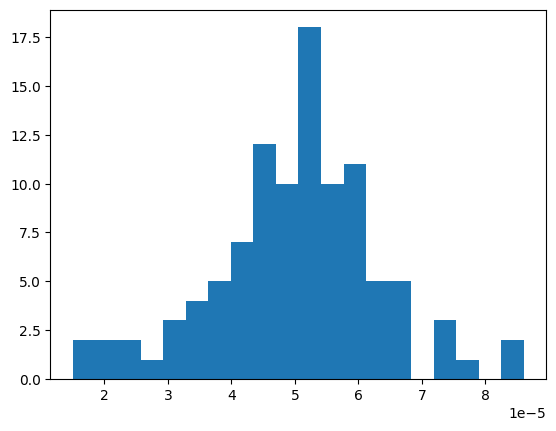

In [13]:
# checking normality assumption for t-test

rand_ind = random.randint(0,data.shape[0])
plt.hist(data[rand_ind,labels == "control"],bins=20)
plt.show()

Well.... kind of. Another option is to use a *[Kolmogorov-Smirnov (KS) test.](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)* The *KS test* is non-paremetric, meaning that it doesn't make any assumptions about the distributions being compared. Also, while the *t-test* is only designed to detect differences in means of distributions, the *KS test* is also sensitive to other kinds of differences. But a downside to the *KS test* is that it's typically less powerful than the *t-test* for detecting differences between means of distributions.

Anyway, we'll go ahead with the *t-test* since that's the standard test for differential expression analysis. But if you prefer the *KS test,* that only requires changing one line of code, so I'll leave a comment with the line of code to use for the *KS test* instead.

Ok, let's try to actually do this differential expression check now. We're eventually going to iterate over the dataset and check every gene, but let's just start with one gene (the first, at index 0) for now so we can figure out what we need to do.

To start, we'll split the distribution into two separate arrays: one with the gene expression for control samples, and the other with gene expression for the IPF samples:

In [14]:
control = data[0, labels == "control"]
ipf = data[0, labels == "ipf"]

Quick shape check (trying to do these a lot to catch any mistakes):

In [15]:
print(control.shape)
print(ipf.shape)

(103,)
(103,)


Next, we'll actually perform the *t-test*, using the `ttest_ind` function that we imported from `scipy.stats` at the top. This gives us two values: a test statistic and a p-value.

In [16]:
t_statistic, p_value = ttest_ind(control, ipf, equal_var=False)

print(f"t_statistic: {t_statistic}")
print(f"p_value: {p_value}")

t_statistic: -6.488795191348932
p_value: 1.272179580001477e-09


If you'd prefer to use the *KS test*, just use this line of code instead, with the `ks_2samp` function we imported from `scipy.stats` at the top:

In [17]:
ks_statistic, p_value = ks_2samp(control, ipf)

print(f"ks_statistic: {ks_statistic}")
print(f"p_value: {p_value}")

ks_statistic: 0.4368932038834951
p_value: 3.264129457102852e-09


Ok, besides getting the p-value for the statistical test, we also want to calculate something called the $\log_2$(fold change) between the mean expression level in each condition:

$$
\log_2 \left( \frac{\text{Expression Mean (IPF)}}{\text{Expression Mean (Control)}} \right)
$$

The inside fraction $\frac{\text{Expression Mean (IPF)}}{\text{Expression Mean (Control)}}$ is the fold change. This tells us how different the mean expression of the IPF samples is compared to the control samples. The reason we're using $\log_2$ is to make this measurement symetrical around 0. So if a gene's mean expression in IPF samples is *twice* the mean of the control samples, then $\log_2 \left( \frac{\text{Expression Mean (IPF)}}{\text{Expression Mean (Control)}} \right) = 1$. If it's *half* the mean of the control samples, then $\log_2 \left( \frac{\text{Expression Mean (IPF)}}{\text{Expression Mean (Control)}} \right) = -1$.

One more thing before we actualy calculate this -- if either of the means is 0, that will cause a problem for us. We can't divide by 0, and we also can't do $\log_2(0)$. We'll deal with this by defining a very small constant called `epsilon` and adding it to both means before doing the calculation.

Here's how this calculation is done, again using the first gene (index 0) as an example:

In [18]:
epsilon = 1e-8  # small constant to avoid division by zero

control_mean = np.mean(control)
ipf_mean = np.mean(ipf)

# calculate log2(fold change), adding epsilon to avoid division by 0
FC = (ipf_mean + epsilon) / (control_mean + epsilon)
log2_FC = np.log2(FC)

print(log2_FC)

0.8107848233591965


Ok, that's basically it! Now we just need to go through and do this for every gene, and save the `p_value` and `log2_FC` for each one.

In [19]:
# t-test attempt, now for every gene

p_values = []
log2_FCs = []

epsilon = 1e-8  # small constant to avoid division by zero

for i in range(data.shape[0]):
    
    control = data[i, labels == "control"]
    ipf = data[i, labels == "ipf"]

    # perform t-test
    t_statistic, p_value = ttest_ind(control, ipf, equal_var=False)
    
    ## if you'd rather do the KS test, just use this line instead
    # ks_statistic, p_value = ks_2samp(control, ipf)

    # save p_value for this gene
    p_values.append(p_value)


    # calculate means for each condition
    control_mean = np.mean(control)
    ipf_mean = np.mean(ipf)

    # calculate log2(fold change), adding epsilon to avoid division by 0
    FC = (ipf_mean + epsilon) / (control_mean + epsilon)
    log2_FC = np.log2(FC)
    
    # save log2_FC for this gene
    log2_FCs.append(log2_FC)


# cast results to numpy arrays
p_values = np.array(p_values)
log2_FCs = np.array(log2_FCs)


Next we'll do a [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction), multiplying each p-value by the number of tests we did. [Here's a great comic explaining why this is necessary.](https://xkcd.com/882/)

In [20]:
p_values_bonf = p_values * len(genes)

Now we can use our `p_values_bonf` and `log2_FCs` arrays to select a list of differentially expressed genes (DEGs) between the two conditions. The threshold choice is somewhat arbitrary here. I'm going to use `p_values_bonf <= 0.01` to be especially rigorous in terms of statistical significance, and `np.abs(log2_FCs) >= 2` to select genes with a very large effect size (the IPF mean must be greater than 4x or less than 1/4 the control mean).

This `np.abs(log2_FCs) >= 2` cutoff is probably too strict, and in a real-life scenario it would probably make more sense to use `np.abs(log2_FCs) >= 1`. But for this dataset, `np.abs(log2_FCs) >= 1` yields quite a lot of DEGs, so for the purposes of this demo I'm trying to narrow down the list to make the next plot we're going to do easier.

(**NOTE:** sometimes the combination of p-values and log2_FC like this is called *biological significance,* since it requires statistical significance (determined by the p-value) as well as biological relevance (determined by the log2_FC, which measures the effect size). 

In [21]:
to_keep = (p_values_bonf <= 0.01) & (np.abs(log2_FCs) >= 2)

sig_genes = genes[to_keep]
sig_log2_FCs = log2_FCs[to_keep]
sig_p_values_bonf = p_values_bonf[to_keep]
sig_data = data[to_keep, :]

Some quick checks to see how many DEGs this yielded:

In [22]:
print(f"Number of DEGs: {len(sig_genes)}")
print(f"Total number of genes: {len(genes)}")
print(f"DEG percentage: {len(sig_genes) / len(genes) * 100}")
print()
print(f"Number of upregulated DEGs: {np.sum(sig_log2_FCs>0)}")
print(f"Number of downregulated DEGs: {np.sum(sig_log2_FCs<0)}")


Number of DEGs: 188
Total number of genes: 18838
DEG percentage: 0.997982800721945

Number of upregulated DEGs: 154
Number of downregulated DEGs: 34


If we want, we can also print out the list of DEGs to take a look. This might also be a good time to check [Enrichr](https://maayanlab.cloud/Enrichr) to see if there's anything interesting about them.

In [23]:
# for i in range(len(sig_genes)):
#     if sig_log2_FCs[i] > 0:
#         print(sig_genes[i])

Finally, we'll save these results to CSV files -- one for the list of upregulated DEGs, and one for the list of downregulated DEGs.

In [24]:
# saving upregulated DEGs         
output_file = "output/upregulated_DEGs.csv"
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    writer.writerow(["gene", "p_value", "log2_FC"])

    for i in range(len(sig_genes)):
        if sig_log2_FCs[i] > 0:
            writer.writerow([sig_genes[i], sig_p_values_bonf[i], sig_log2_FCs[i]])


# saving downregulated DEGs         
output_file = "output/downregulated_DEGs.csv"
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    writer.writerow(["gene", "p_value", "log2_FC"])

    for i in range(len(sig_genes)):
        if sig_log2_FCs[i] < 0:
            writer.writerow([sig_genes[i], sig_p_values_bonf[i], sig_log2_FCs[i]])

### **Step 3:** Heatmap plot

Ok, now let's visualize these differential expression results with a nice heatmap plot. To do this, we need to make a log2_FC expression matrix for the genes that came up significant. This will keep the color scheme smooth and balanced, because each element will have the same scale. 

To do this, we'll start by making a zeros array called `sig_data_log2fc` with the same shape as `sig_data`.

In [25]:
sig_data_log2fc = np.zeros_like(sig_data)

Next, we'll iterate over the genes and do a calculation for each one similar to the log2_FC calculation we did previously. Except this time, rather than finding the log2_FC of the *IPF mean* relative to the *control mean*, we'll find the log2_FC of each individual sample (of both conditions) relative to the control mean. 

In [26]:
epsilon = 1e-8  # small constant to avoid division by zero


for i in range(len(sig_genes)):
    
    control_mean =  np.mean(sig_data[i,labels == "control"])
    
    sig_data_log2fc[i,:] = np.log2((sig_data[i,:]+epsilon) / (control_mean +epsilon))
    

Now here's the actual code for the plot, using the [seaborn](https://seaborn.pydata.org/) package we imported at the top:

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


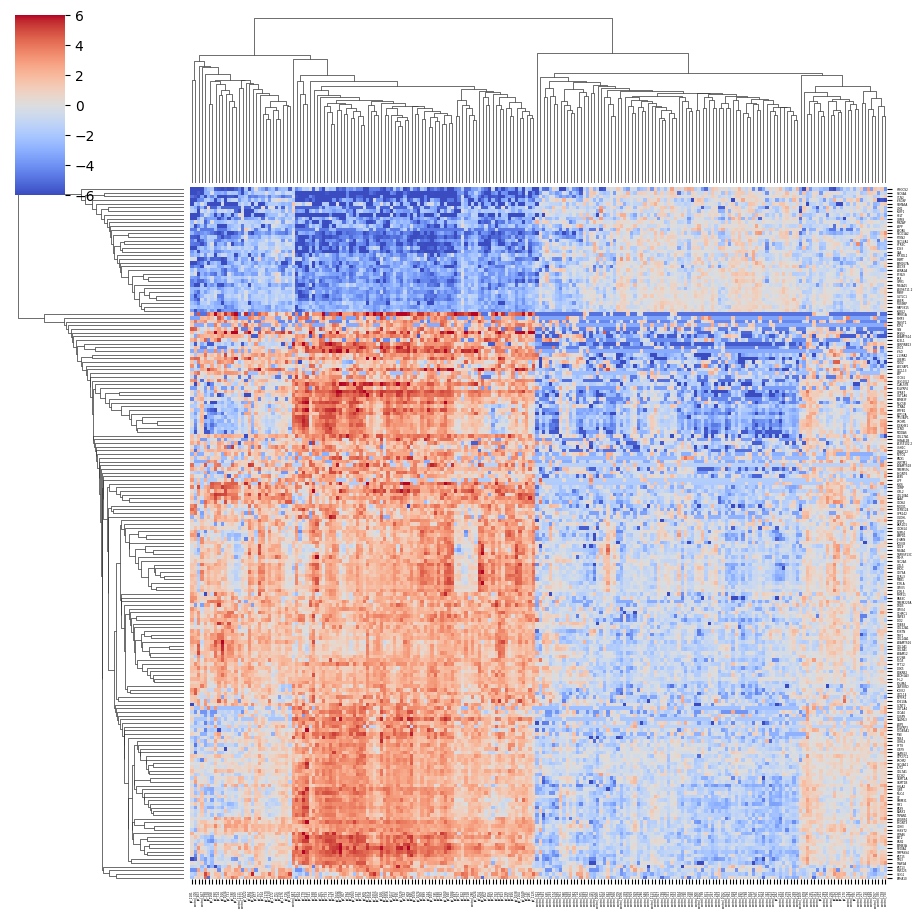

In [27]:
sns_plot = sns.clustermap(sig_data_log2fc, xticklabels=samples, yticklabels= sig_genes, cmap="coolwarm", vmin=-6, vmax=6)

# changing font sizes for x and y labels
sns_plot.ax_heatmap.set_xticklabels(sns_plot.ax_heatmap.get_xmajorticklabels(), fontsize=2)
sns_plot.ax_heatmap.set_yticklabels(sns_plot.ax_heatmap.get_ymajorticklabels(), fontsize=2)


sns_plot.savefig("output/heatmap.pdf")

plt.show()

### **Step 4:** More plots

In this section, we'll make some more plots to further explore and communicate these results.

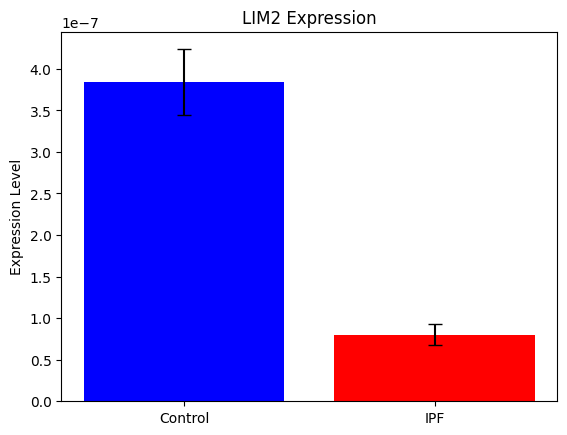

In [34]:
## expression bar plot

gene_to_plot = "LIM2"

control_expression = data[genes==gene_to_plot, labels == "control"]
ipf_expression = data[genes==gene_to_plot, labels == "ipf"]

control_mean = np.mean(control_expression)
control_sem = np.std(control_expression) / np.sqrt(len(control_expression))
ipf_mean = np.mean(ipf_expression)
ipf_sem = np.std(ipf_expression) / np.sqrt(len(ipf_expression))

conditions = ['Control', 'IPF']
means = [control_mean, ipf_mean]
errors = [control_sem, ipf_sem]

plt.bar(conditions, means, yerr=errors, capsize=5, color=['blue', 'red'])
plt.ylabel('Expression Level')
plt.title(f'{gene_to_plot} Expression')
# plt.savefig(f"output/{gene_to_plot}_expression_bar.pdf")
plt.show()

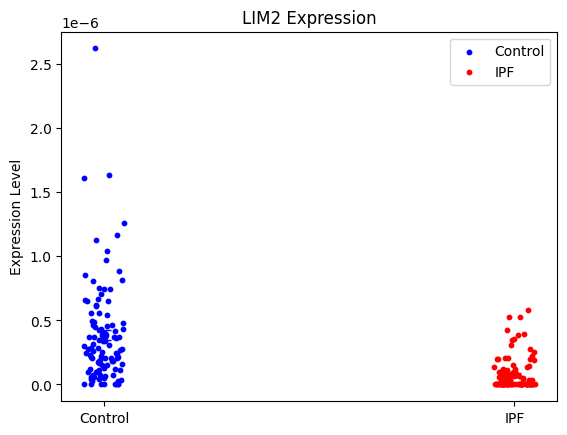

In [36]:
# expression scatter plot

gene_to_plot = "LIM2"

control_expression = data[genes == gene_to_plot, labels == "control"]
ipf_expression = data[genes == gene_to_plot, labels == "ipf"]

control_mean = np.mean(control_expression)
control_sem = np.std(control_expression) / np.sqrt(len(control_expression))
ipf_mean = np.mean(ipf_expression)
ipf_sem = np.std(ipf_expression) / np.sqrt(len(ipf_expression))

def add_jitter(values, jitter_amount=0.05):
    return values + np.random.uniform(-jitter_amount, jitter_amount, size=values.shape)

control_x = add_jitter(np.ones_like(control_expression) * 1)
ipf_x = add_jitter(np.ones_like(ipf_expression) * 2)

plt.scatter(control_x, control_expression, color='blue', label='Control', s=10)  # smaller dots with s=10
plt.scatter(ipf_x, ipf_expression, color='red', label='IPF', s=10)  # smaller dots with s=10

plt.errorbar(1, control_mean, yerr=control_sem, fmt='o', color='blue', capsize=5)
plt.errorbar(2, ipf_mean, yerr=ipf_sem, fmt='o', color='red', capsize=5)

plt.xticks([1, 2], ['Control', 'IPF'])

plt.ylabel('Expression Level')
plt.title(f'{gene_to_plot} Expression')
plt.legend()

# plt.savefig(f"output/{gene_to_plot}_expression_scatter.pdf")
plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


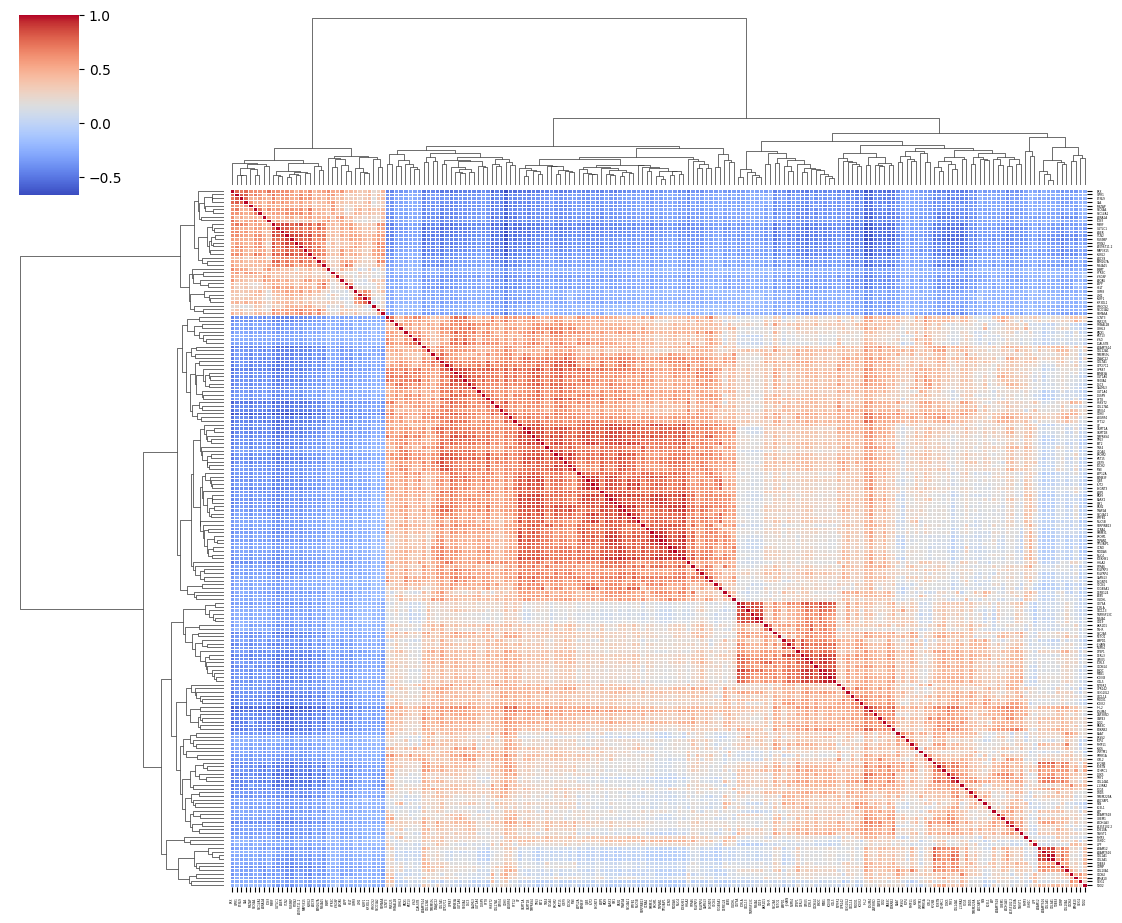

In [40]:
# DEG expression correlation

correlation_matrix = np.corrcoef(sig_data)

sns_plot = sns.clustermap(correlation_matrix, 
                          xticklabels=sig_genes, 
                          yticklabels=sig_genes, 
                          cmap="coolwarm", 
                          annot=False, 
                          linewidths=.5, 
                          figsize=(12, 10))

sns_plot.ax_heatmap.set_xticklabels(sns_plot.ax_heatmap.get_xmajorticklabels(), fontsize=2)
sns_plot.ax_heatmap.set_yticklabels(sns_plot.ax_heatmap.get_ymajorticklabels(), fontsize=2)

# sns_plot.savefig("output/degs_correlation_heatmap.pdf")
plt.show()